In [4]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import rasterio
import rasterio.mask
from rasterio import features
import shapely.geometry
import statsmodels.api as sm

import numpy as np
import matplotlib.pyplot as plt
import seaborn

def ktoe_to_twh(array):
    array *= 11.63e-3
    return array

idx = pd.IndexSlice

ModuleNotFoundError: No module named 'rasterio'

In [3]:
energy_balance = xr.open_dataset('/cluster/work/cpesm/brynmorp/euro-spores/data/annual_energy_balance.nc')


uk_2017_dom_demand = ktoe_to_twh(energy_balance.UK.loc[
    {'cat_code': 'FC_OTH_HH_E', 'year': 2017, 'carrier_code': 'E7000'}
].item())

uk_2017_nondom_demand = ktoe_to_twh(energy_balance.UK.loc[
    {'cat_code': ['FC_IND_E', 'FC_OTH_CP_E'], 'year': 2017, 'carrier_code': 'E7000'}
].sum().item())

uk_2018_dom_demand = ktoe_to_twh(energy_balance.UK.loc[
    {'cat_code': 'FC_OTH_HH_E', 'year': 2018, 'carrier_code': 'E7000'}
].item())

uk_2018_nondom_demand = ktoe_to_twh(energy_balance.UK.loc[
    {'cat_code': ['FC_IND_E', 'FC_OTH_CP_E'], 'year': 2018, 'carrier_code': 'E7000'}
].sum().item())

uk_industry_2018 = ktoe_to_twh(energy_balance.UK.loc[{
    'cat_code': [f'FC_IND_{i}_E' for i in ['IS', 'CPC', 'NFM', 'NMM', 'TE', 'MAC', 'MQ', 'FBT', 'PPP', 'WP', 'CON', 'TL', 'NSP']],
    'year': 2018, 'carrier_code': 'E7000'
}])

raw_load = pd.read_csv('/cluster/work/cpesm/trtim/possibility-for-electricity-autarky/build/electricity-demand-national.csv')

In [104]:
uk_lau1_con = pd.read_excel(
    'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/853754/Sub-national_electricity_consumption_statistics_2005-2018.xlsx',
    sheet_name='2017r', header=[0, 1, 2]
)
uk_lau1_con_all = uk_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2017(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'All')].dropna()
uk_lau1_con_all.index = uk_lau1_con_all.index.rename('LA Code')

uk_lau1_con_dom = uk_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2017(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'Domestic consumers', 'All domestic')].dropna()
uk_lau1_con_dom.index = uk_lau1_con_dom.index.rename('LA Code')


uk_lau1_con_nondom = uk_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2017(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'Non-domestic consumers', 'All non-domestic')].dropna()
uk_lau1_con_nondom.index = uk_lau1_con_nondom.index.rename('LA Code')

/cluster/work/apatt/brynmorp/miniconda/envs/wind-var-calliope/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [5]:
polys_eu = gpd.read_file('../build/merra_2_pop_polys.geojson')
polys_uk = polys_eu[polys_eu.country_co == 'GBR']

In [6]:
gas_lau1_con = pd.read_excel(
    'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/853638/Weather_Uncorrected_Sub-national_gas_consumption_statistics_2016-2018.xlsx',
    sheet_name='2017r', header=[0, 1, 2]
)
gas_lau1_con_all = pd.to_numeric(gas_lau1_con.set_index(
    ('Sub-national weather uncorrected gas sales and numbers of customers, 2017', 'Unnamed: 3_level_1', 'LA Code')
)[('Sales (GWh)', 'Unnamed: 10_level_1', 'Total consumption')].dropna(), errors='coerce')
gas_lau1_con_all.index = gas_lau1_con_all.index.rename('LA Code')

gas_lau1_con_dom = pd.to_numeric(gas_lau1_con.set_index(
    ('Sub-national weather uncorrected gas sales and numbers of customers, 2017', 'Unnamed: 3_level_1', 'LA Code')
)[('Sales (GWh)', 'Unnamed: 8_level_1', 'Domestic consumption')].dropna(), errors='coerce')
gas_lau1_con_dom.index = gas_lau1_con_dom.index.rename('LA Code')


gas_lau1_con_nondom = pd.to_numeric(gas_lau1_con.set_index(
    ('Sub-national weather uncorrected gas sales and numbers of customers, 2017', 'Unnamed: 3_level_1', 'LA Code')
)[('Sales (GWh)', 'Unnamed: 9_level_1', 'Non-domestic consumption')].dropna(), errors='coerce')
gas_lau1_con_nondom.index = gas_lau1_con_nondom.index.rename('LA Code')

# Shapefile of the LAU1 units
uk_lau1_units = gpd.read_file('http://geoportal1-ons.opendata.arcgis.com/datasets/b6d2e15801de45328b760a4f55d74318_0.geojson')
uk_lau1_units = uk_lau1_units.set_index('LAD19CD')[['LAD19NM', 'geometry']]
uk_lau1_units.index = uk_lau1_units.index.rename('LA Code')

# Population data of LAU1 units
lau_conversion_2018 = pd.read_excel(
    'https://ec.europa.eu/eurostat/documents/345175/501971/EU-28-LAU-2018-NUTS-2016.xlsx',
    sheet_name='UK', header=0
)
pop_2018 = lau_conversion_2018.set_index('LAU NAME NATIONAL')

pop_2018 = pop_2018.reindex(uk_lau1_units.LAD19NM).set_index(uk_lau1_units.index).dropna(how='all')
gas_lau1_con_all = gas_lau1_con_all.reindex(uk_lau1_units.index).dropna(how='all')
gas_lau1_con_dom = gas_lau1_con_dom.reindex(uk_lau1_units.index).dropna(how='all')
gas_lau1_con_nondom = gas_lau1_con_nondom.reindex(uk_lau1_units.index).dropna(how='all')

uk_lau1_units = uk_lau1_units.reindex(gas_lau1_con_all.index).assign(
    population=pop_2018['POPULATION'], 
    nuts3=pop_2018['NUTS 3 CODE'], 
    area_m2=pop_2018['TOTAL AREA (m2)'],
    city=(~pop_2018['CITY_NAME'].isnull()).astype('float'),
    gas_con_all=gas_lau1_con_all / 1000,
    gas_con_dom=gas_lau1_con_dom / 1000,
    gas_con_nondom=gas_lau1_con_nondom / 1000
)
uk_lau1_units['pop_density'] = uk_lau1_units['population'] / uk_lau1_units['area_m2']

In [9]:
gpd.read_file('http://geoportal1-ons.opendata.arcgis.com/datasets/1d78d47c87df4212b79fe2323aae8e08_0.geojson')

HTTPError: HTTP Error 504: GATEWAY_TIMEOUT

In [12]:
gpd.read_file('http://opendata.arcgis.com/datasets/83f458a118604169b599000411f364bf_0.geojson')

DriverError: '/vsimem/3e8567b54a8e472b8294616503eaf4ad' not recognized as a supported file format.

In [8]:
foo = gpd.overlay(uk_lau1_units.reset_index(), polys_uk.to_crs(uk_lau1_units.crs))
foo['area'] = foo.area
_df = foo.groupby('LA Code').agg({'2017': {'weighted_hdd': lambda x: np.average(x, weights=foo.loc[x.index, "area"])}})
uk_lau1_units = uk_lau1_units.assign(hdd=_df.iloc[:, 0])

/cluster/work/apatt/brynmorp/miniconda/envs/wind-var-calliope/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [9]:
uk_lau1_units['pop_weight'] = uk_lau1_units.gas_con_dom.sum() * uk_lau1_units.population.apply(lambda x: x / uk_lau1_units.population.sum())

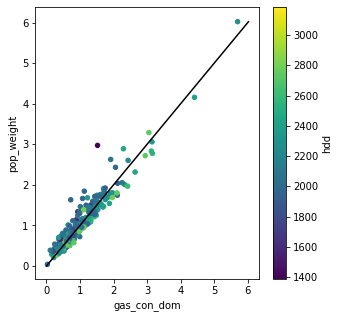

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
_max = uk_lau1_units[['gas_con_dom', 'pop_weight']].max().max()
ax.plot((0, _max), (0, _max), color='black')
pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_dom', y='pop_weight', ax=ax, c='hdd', cmap='viridis')

In [29]:
model = sm.OLS(uk_lau1_units.dropna().gas_con_dom, uk_lau1_units.dropna()[["population", "hdd"]]).fit()
model.summary()
pop_hdd_regression = model.predict(uk_lau1_units.dropna()[["population", "hdd"]])

In [28]:
model = sm.OLS(uk_lau1_units.dropna().gas_con_dom, uk_lau1_units.dropna().population).fit()
model.summary()
pop_regression = model.predict(uk_lau1_units.dropna().population)

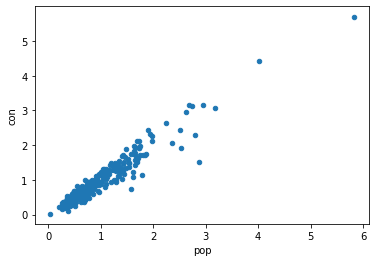

In [37]:
pd.DataFrame([pop_hdd_regression, pop_regression, uk_lau1_units.dropna().gas_con_dom], index=('pop_hdd', 'pop', 'con')).T.plot.scatter('pop', 'con')

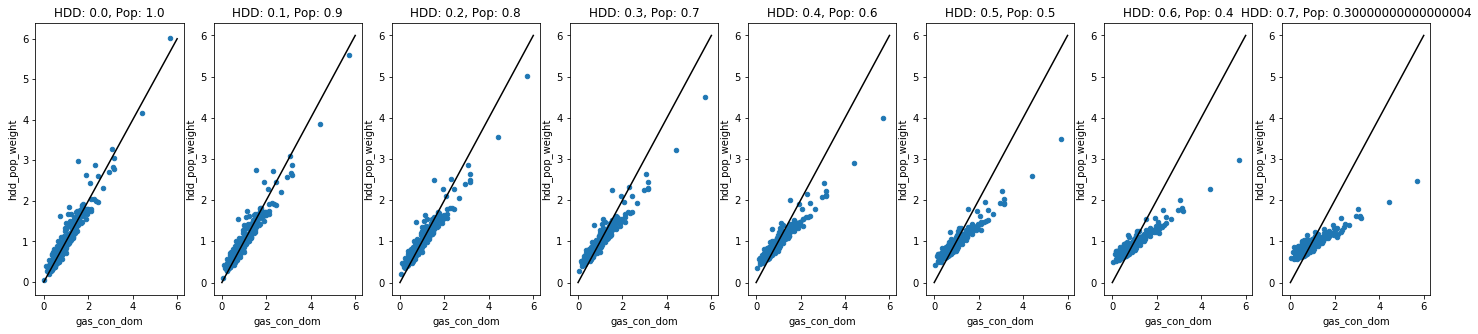

In [84]:
fig, ax = plt.subplots(1, 8, figsize=(25, 5))

for i in range(0, 8):
    weight = i / 10
    uk_lau1_units['hdd_pop_weight'] = uk_lau1_units.gas_con_dom.sum() * (
        weight*uk_lau1_units.hdd.apply(lambda x: x / uk_lau1_units.hdd.sum()) + 
        (1-weight)*uk_lau1_units.population.apply(lambda x: x / uk_lau1_units.population.sum())
    )
    ax[i].plot((0, 6), (0, 6), color='black')
    pd.DataFrame(uk_lau1_units).plot.scatter(x='gas_con_dom', y='hdd_pop_weight', ax=ax[i])
    ax[i].set_title(f"HDD: {weight}, Pop: {1 - weight}")

In [308]:
# Bottom-up LAU1 (NUTS4) consumption
uk_lau1_con = pd.read_excel(
    'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/853754/Sub-national_electricity_consumption_statistics_2005-2018.xlsx',
    sheet_name='2018', header=[0, 1, 2]
)

uk_lau1_con_all = uk_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2018(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'All')].dropna()
uk_lau1_con_all.index = uk_lau1_con_all.index.rename('LA Code')

uk_lau1_con_dom = uk_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2018(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'Domestic consumers', 'All domestic')].dropna()
uk_lau1_con_dom.index = uk_lau1_con_dom.index.rename('LA Code')


uk_lau1_con_nondom = uk_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2018(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'Non-domestic consumers', 'All non-domestic')].dropna()
uk_lau1_con_nondom.index = uk_lau1_con_nondom.index.rename('LA Code')


# Shapefile of the LAU1 units
uk_lau1_units = gpd.read_file('http://geoportal1-ons.opendata.arcgis.com/datasets/b6d2e15801de45328b760a4f55d74318_0.geojson')
uk_lau1_units = uk_lau1_units.set_index('LAD19CD')[['LAD19NM', 'geometry']]
uk_lau1_units.index = uk_lau1_units.index.rename('LA Code')

# Population data of LAU1 units
lau_conversion_2018 = pd.read_excel(
    'https://ec.europa.eu/eurostat/documents/345175/501971/EU-28-LAU-2018-NUTS-2016.xlsx',
    sheet_name='UK', header=0
)
pop_2018 = lau_conversion_2018.set_index('LAU NAME NATIONAL')

# Add pop and consumption data to geodataframe

pop_2018 = pop_2018.reindex(uk_lau1_units.LAD19NM).set_index(uk_lau1_units.index).dropna(how='all')
uk_lau1_con_all = uk_lau1_con_all.reindex(uk_lau1_units.index).dropna(how='all')
uk_lau1_con_dom = uk_lau1_con_dom.reindex(uk_lau1_units.index).dropna(how='all')
uk_lau1_con_nondom = uk_lau1_con_nondom.reindex(uk_lau1_units.index).dropna(how='all')

uk_lau1_units = uk_lau1_units.reindex(uk_lau1_con_all.index).assign(
    population=pop_2018['POPULATION'], 
    nuts3=pop_2018['NUTS 3 CODE'], 
    area_m2=pop_2018['TOTAL AREA (m2)'],
    city=(~pop_2018['CITY_NAME'].isnull()).astype('float'),
    consumption_all=uk_lau1_con_all['Total consumption'] / 1000,
    consumption_dom=uk_lau1_con_dom / 1000,
    consumption_nondom=uk_lau1_con_nondom / 1000
)
uk_lau1_units['pop_density'] = uk_lau1_units['population'] / uk_lau1_units['area_m2']
# National-level data
eu_nuts0_pop = pd.read_csv('/cluster/work/cpesm/trtim/possibility-for-electricity-autarky/build/national/population.csv', header=0)

/cluster/work/apatt/brynmorp/miniconda/envs/wind-var-calliope/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [309]:
uk_lau1_units = uk_lau1_units.assign(
    pop_con_all=uk_lau1_units.population.transform(lambda x: x / eu_nuts0_pop[eu_nuts0_pop.id == 'GBR'].population_sum.values.item()) * (uk_2018_dom_demand + uk_2018_nondom_demand),
    pop_con_dom=uk_lau1_units.population.transform(lambda x: x / eu_nuts0_pop[eu_nuts0_pop.id == 'GBR'].population_sum.values.item()) * uk_2018_dom_demand,
    pop_con_nondom=uk_lau1_units.population.transform(lambda x: x / eu_nuts0_pop[eu_nuts0_pop.id == 'GBR'].population_sum.values.item()) * uk_2018_nondom_demand
)

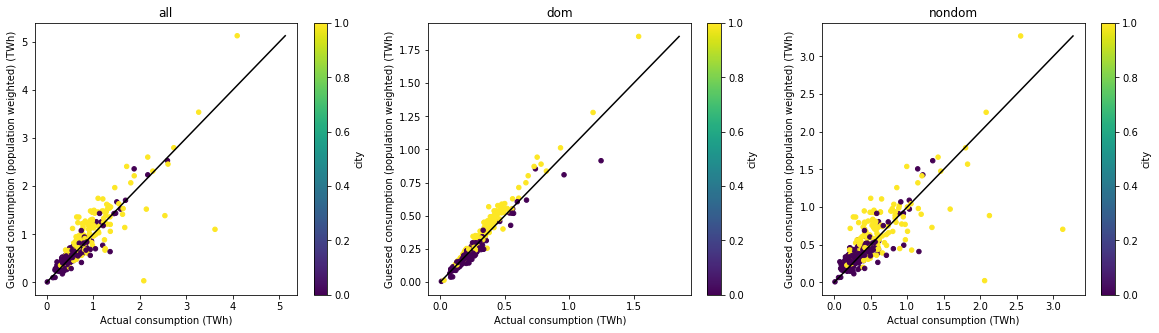

In [310]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

_ax = 0
for i in ['all', 'dom', 'nondom']:
    pd.DataFrame(uk_lau1_units).plot.scatter(x=f'consumption_{i}', y=f'pop_con_{i}', c='city', colormap='viridis', ax=ax[_ax])
    _max = uk_lau1_units[[f'pop_con_{i}', f'consumption_{i}']].max().max()
    ax[_ax].plot((0, _max), (0, _max), color='black')
    ax[_ax].set_xlabel('Actual consumption (TWh)')
    ax[_ax].set_ylabel('Guessed consumption (population weighted) (TWh)')
    ax[_ax].set_title(i)
    _ax += 1

In [51]:
# LAU2 -> LAU1 conversion, using a mashup of 2013 and 2016 data 
# 2013 matches our LAU2 data, but 2016 matches the measured LAU1 data

lau_conversion_2013 = pd.read_excel(
    'https://ec.europa.eu/eurostat/documents/345175/501971/EU-28_2013.xlsx',
    sheet_name='UK', header=0
)
lau_conversion = lau_conversion_2013.set_index('LAU2_NAT_CODE_NEW')['LAU1_NAT_CODE_NEW'].dropna()
lau_conversion.index = 'UK' + lau_conversion.index

lau_conversion_2016 = pd.read_excel(
    'https://ec.europa.eu/eurostat/documents/345175/501971/EU-28_LAU_2016',
    sheet_name='UK', header=0
)

_2016 = (
    lau_conversion_2016
    .dropna(subset=['LAU1_NAT_CODE_NEW'])
    .set_index(['NUTS3_13', 'LAU1_NAT_CODE'])[['LAU1_NAT_CODE_NEW']]
    .drop_duplicates()
)
_2013 = (
    lau_conversion_2013
    .dropna(subset=['LAU1_NAT_CODE_NEW'])
    .set_index(['NUTS_3_2013_CODE', 'LAU1_NAT_CODE'])[['LAU1_NAT_CODE_NEW']]
    .drop_duplicates()
)

for i in _2016.index:
    try:
        _2013.loc[i, 'LAU1_NAT_CODE_NEWER'] = _2016.loc[i, 'LAU1_NAT_CODE_NEW'].values
    except:
        continue
_2013.loc[('UKH34', '22UK'), 'LAU1_NAT_CODE_NEWER'] = 'E07000074'  # typo in the excel, should be UKH36

lau_conversion = lau_conversion.map(_2013.set_index('LAU1_NAT_CODE_NEW')['LAU1_NAT_CODE_NEWER'])

/cluster/work/apatt/brynmorp/miniconda/envs/wind-var-calliope/lib/python3.7/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/cluster/work/apatt/brynmorp/miniconda/envs/wind-var-calliope/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/cluster/work/apatt/brynmorp/miniconda/envs/wind-var-calliope/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [111]:
# top-down ~LAU2 data
eu_lau2_con = pd.read_csv('/cluster/work/cpesm/trtim/possibility-for-electricity-autarky/build/municipal/demand.csv', header=0)
eu_lau2_pop = pd.read_csv('/cluster/work/cpesm/trtim/possibility-for-electricity-autarky/build/municipal/population.csv', header=0)

eu_lau2_con['industrial_demand'] = eu_lau2_con.industrial_demand_fraction * eu_lau2_con.demand_twh_per_year
eu_lau2_pop['area'] = eu_lau2_pop.population_sum / eu_lau2_pop.density_p_per_km2

In [112]:
# LAU2 -> LAU1
uk_lau1_pop = eu_lau2_pop.set_index('id').groupby(lau_conversion).sum()
uk_lau1_pop['density_p_per_km2'] = uk_lau1_pop.population_sum / uk_lau1_pop.area
uk_lau1_pop['percent'] = uk_lau1_pop.population_sum / eu_nuts0_pop[eu_nuts0_pop.id == 'GBR'].population_sum.values.item()

uk_lau1_con_guess = eu_lau2_con.set_index('id').groupby(lau_conversion).sum()
uk_lau1_con_guess['industrial_demand_fraction'] = uk_lau1_con_guess.industrial_demand / uk_lau1_con_guess.demand_twh_per_year
uk_lau1_con_guess = uk_lau1_con_guess.reindex(uk_lau1_con_all.index)
uk_lau1_con_guess['actual_consumption_twh'] = uk_lau1_con_all / 1000
uk_lau1_con_guess['actual_dom_consumption_twh'] = uk_lau1_con_dom / 1000
uk_lau1_con_guess['actual_nondom_consumption_twh'] = uk_lau1_con_nondom / 1000
uk_lau1_con_guess['non_ind_demand_twh_per_year'] = uk_lau1_con_guess.demand_twh_per_year - uk_lau1_con_guess.industrial_demand

uk_lau1_con_from_raw = uk_lau1_pop.percent * raw_load.loc[raw_load.country_code == 'GBR', 'twh_per_year'].values.item()
uk_lau1_con_guess['demand_from_raw_twh'] = uk_lau1_con_from_raw.reindex(uk_lau1_con_guess.index)

uk_lau1_dom_con_from_raw = uk_lau1_pop.percent * uk_2017_dom_demand  
uk_lau1_nondom_con_from_raw = uk_lau1_pop.percent * uk_2017_nondom_demand  
uk_lau1_con_guess['demand_dom_from_raw'] = uk_lau1_dom_con_from_raw.reindex(uk_lau1_con_guess.index)
uk_lau1_con_guess['demand_nondom_from_raw'] = uk_lau1_nondom_con_from_raw.reindex(uk_lau1_con_guess.index)

In [172]:
len(uk_lau1_con_guess.dropna())

334

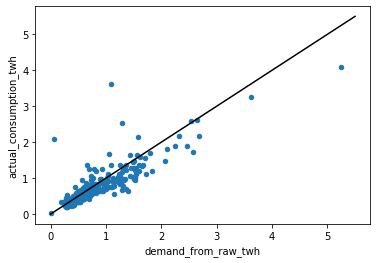

In [115]:
# How well does 'all demand' from both bottom-up and top-down analyses look
ax = uk_lau1_con_guess.plot.scatter(x='demand_from_raw_twh', y='actual_consumption_twh')
ax.plot((0, 5.5), (0, 5.5), color='black')

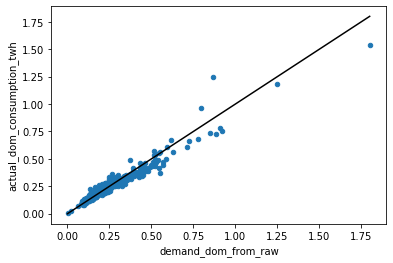

In [117]:
# Better match if looking at just domestic demand
ax = uk_lau1_con_guess.plot.scatter(x='demand_dom_from_raw', y='actual_dom_consumption_twh')
ax.plot((0, 1.8), (0, 1.8), color='black')

In [ ]:
# Clearly worse for non-domestic - we need another data source!
ax = uk_lau1_con_guess.plot.scatter(x='demand_nondom_from_raw', y='actual_nondom_consumption_twh')
ax.plot((0, 2), (0, 2), color='black')

# See if N. households is a better way to disaggregate the data

In [314]:
households = pd.read_csv(
    'https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/cens_11dwob_r3.tsv.gz', 
    delimiter='\t', header=0
).set_index('housing,building,unit,time\geo')
households.index = households.index.str.split(',', expand=True).rename(['housing', 'building', 'unit', 'time'])
households.columns = households.columns.str.strip()
nuts3_2010_units = gpd.read_file('https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/geojson/NUTS_RG_03M_2010_4326_LEVL_3.geojson')
uk_nuts3_2010 = nuts3_2010_units[nuts3_2010_units.CNTR_CODE == 'UK']


In [315]:
# LAU1 -> NUTS3
uk_lau1_units['area3035'] = uk_lau1_units.to_crs('epsg:3035').area

# Slice up the LAU1 units into NUTS3, where we know there is not a perfect overlap (some LAU1 units will be chopped in half, for instance)
nuts2016_to_nuts2010 = gpd.overlay(uk_nuts3_2010, uk_lau1_units)
nuts2016_to_nuts2010_area_weight = nuts2016_to_nuts2010.to_crs('epsg:3035').area / nuts2016_to_nuts2010.area3035

uk_nuts3_2010_data = (
    nuts2016_to_nuts2010[['population', 'consumption_nondom', 'consumption_dom', 'consumption_all', 'pop_con_all', 'pop_con_dom', 'pop_con_nondom', 'city']]
    .mul(nuts2016_to_nuts2010_area_weight, axis=0)  # Use area of sliced up regions to weight the values coming in
    .set_index(nuts2016_to_nuts2010.id)
    .groupby(level=0).sum()
)

In [316]:
# Weighting factors for each NUTS3 region based on household numbers
all_hh_percent = (
    households.T.reindex(uk_nuts3_2010_data.index)[('DW', 'TOTAL',)].astype(float) 
    / households.loc[('DW', 'TOTAL',), 'UK'].values.item()
)
nres_hh_percent = (
    households.T.reindex(uk_nuts3_2010_data.index)[('DW', 'NRES',)].astype(float) 
    / households.loc[('DW', 'NRES',), 'UK'].values.item()
)
res_hh_percent = (
    (households.T.reindex(uk_nuts3_2010_data.index)[('DW', 'TOTAL',)].astype(float) 
     - households.T.reindex(uk_nuts3_2010_data.index)[('DW', 'NRES',)].astype(float))
    / (households.loc[('DW', 'TOTAL',), 'UK'].values.item() 
       - households.loc[('DW', 'NRES',), 'UK'].values.item())
)

In [317]:
uk_nuts3_2010_data['hh_con_all'] = all_hh_percent * (uk_2018_dom_demand + uk_2018_nondom_demand)
uk_nuts3_2010_data['hh_con_nondom'] = nres_hh_percent * uk_2018_nondom_demand
uk_nuts3_2010_data['hh_con_dom'] = res_hh_percent * uk_2018_dom_demand

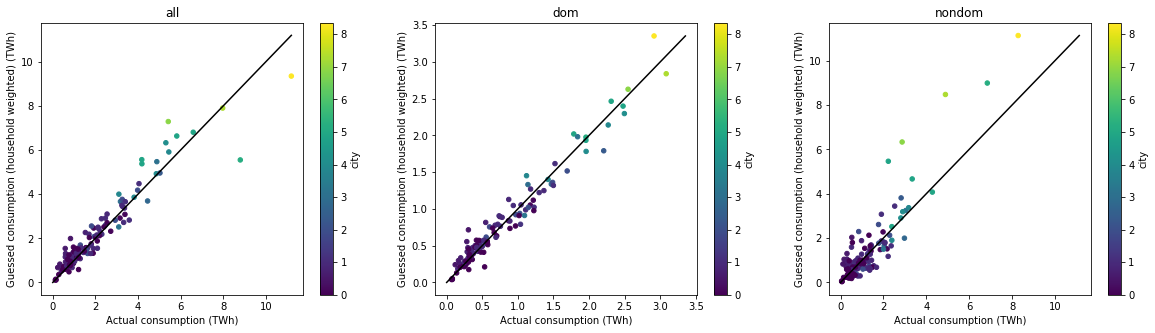

In [318]:
# See how well it matches for all households vs actual demand 
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

_ax = 0
for i in ['all', 'dom', 'nondom']:
    uk_nuts3_2010_data.plot.scatter(x=f'consumption_{i}', y=f'hh_con_{i}', c='city', colormap='viridis', ax=ax[_ax])
    _max = uk_nuts3_2010_data[[f'hh_con_{i}', f'consumption_{i}']].max().max()
    ax[_ax].plot((0, _max), (0, _max), color='black')
    ax[_ax].set_xlabel('Actual consumption (TWh)')
    ax[_ax].set_ylabel('Guessed consumption (household weighted) (TWh)')
    ax[_ax].set_title(i)
    _ax += 1
    

In [322]:
uk_nuts3_2010_data[uk_nuts3_2010_data.pop_con_all == 0]

,population,consumption_nondom,consumption_dom,consumption_all,pop_con_all,pop_con_dom,pop_con_nondom,city,hh_con_all,hh_con_nondom,hh_con_dom
id,,,,,,,,,,,
UKK21,0.0,0.552796,0.417990,0.970787,0.0,0.0,0.0,0.0,1.600930,1.799170,0.574457
UKM61,0.0,0.449268,0.310969,0.760237,0.0,0.0,0.0,0.0,0.481902,0.213955,0.174873
UKM64,0.0,0.060696,0.080003,0.140699,0.0,0.0,0.0,0.0,0.145972,0.038901,0.053125


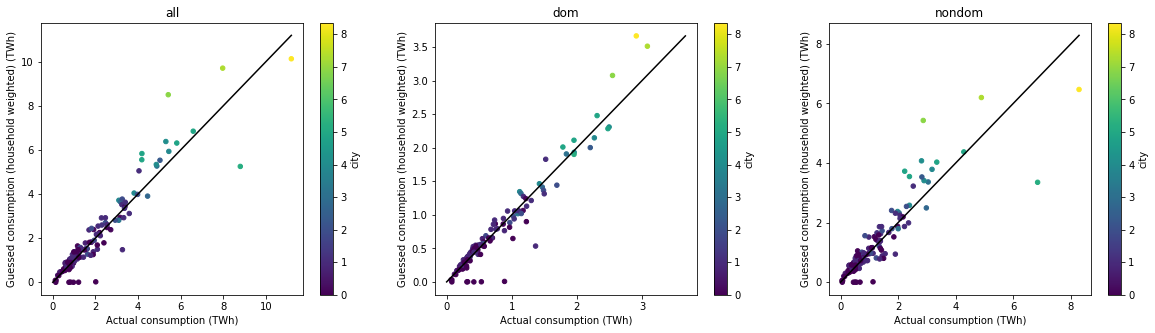

In [319]:
# See how well it matches between population weighted vs actual demand at NUTS3 aggregation
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

_ax = 0
for i in ['all', 'dom', 'nondom']:
    uk_nuts3_2010_data.plot.scatter(x=f'consumption_{i}', y=f'pop_con_{i}', c='city', colormap='viridis', ax=ax[_ax])
    _max = uk_nuts3_2010_data[[f'pop_con_{i}', f'consumption_{i}']].max().max()
    ax[_ax].plot((0, _max), (0, _max), color='black')
    ax[_ax].set_xlabel('Actual consumption (TWh)')
    ax[_ax].set_ylabel('Guessed consumption (household weighted) (TWh)')
    ax[_ax].set_title(i)
    _ax += 1

# See if land use is another possible disaggregation data source

In [324]:
europe_shape = gpd.read_file('/cluster/work/cpesm/trtim/possibility-for-electricity-autarky/build/national/units.geojson')
with rasterio.open(
    '/cluster/work/cpesm/brynmorp/euro-spores/data/urban_atlas/clc2018_clc2018_v2018_20_raster100m/CLC2018_CLC2018_V2018_20.tif'
) as src:
    clc = src.read(1)
    crs = src.crs
    uk_lau1_units_converted = uk_lau1_units.to_crs(crs)
    uk_nuts3_2010_converted = uk_nuts3_2010.to_crs(crs)
    images = {}
    transforms = {}
    images_nuts = {}
    transforms_nuts = {}
    for i in uk_lau1_units_converted.index:
        images[i], transforms[i] = rasterio.mask.mask(
            src, [uk_lau1_units_converted.loc[i, 'geometry']], 
            crop=True
        )
    for i in uk_nuts3_2010_converted.index:
        images_nuts[i], transforms_nuts[i] = rasterio.mask.mask(
            src, [uk_nuts3_2010_converted.loc[i, 'geometry']], 
            crop=True
        )
    
    img_uk, transform_uk = rasterio.mask.mask(
        src, europe_shape[europe_shape.country_code == 'GBR'].to_crs(crs).geometry.values, 
        crop=True
    )

In [361]:
def mask_raster_output(array, sub_sector):
    if sub_sector == 'all':
        return ((array > 100) & (array < 140)).sum()
    elif sub_sector == 'nondom':
        return ((array == 121) | (array == 112)).sum()
        #return ((array > 120) & (array < 140)).sum()
    if sub_sector == 'dom':
        return ((array > 100) & (array < 120)).sum()
    
raster_info = pd.DataFrame(index=uk_lau1_units.index)
for k, v in images.items():
    raster_info.loc[k, 'raster_size'] = v[0].size
    raster_info.loc[k, 'raster_dom'] = mask_raster_output(v[0], 'dom')
    raster_info.loc[k, 'raster_nondom'] = mask_raster_output(v[0], 'nondom')
    raster_info.loc[k, 'raster_all'] = mask_raster_output(v[0], 'all')


uk_dom = mask_raster_output(img_uk[0], 'dom')
uk_non_dom = mask_raster_output(img_uk[0], 'nondom')
uk_all = mask_raster_output(img_uk[0], 'all')

uk_lau1_units = uk_lau1_units.assign(
    raster_con_dom=uk_2018_dom_demand * raster_info.raster_dom / uk_dom,
    raster_con_nondom=uk_2018_nondom_demand * raster_info.raster_nondom / uk_non_dom,
    raster_con_all=(uk_2018_dom_demand + uk_2018_nondom_demand) * raster_info.raster_all / uk_all
)

raster_info = pd.DataFrame(index=uk_nuts3_2010.id)
for k, v in images_nuts.items():
    raster_info.loc[uk_nuts3_2010.loc[k, 'id'], 'raster_size'] = v[0].size
    raster_info.loc[uk_nuts3_2010.loc[k, 'id'], 'raster_dom'] = mask_raster_output(v[0], 'dom')
    raster_info.loc[uk_nuts3_2010.loc[k, 'id'], 'raster_nondom'] = mask_raster_output(v[0], 'nondom')
    raster_info.loc[uk_nuts3_2010.loc[k, 'id'], 'raster_all'] =  mask_raster_output(v[0], 'all')

uk_nuts3_2010_data = uk_nuts3_2010_data.assign(
    raster_con_dom=uk_2018_dom_demand * raster_info.raster_dom / uk_dom,
    raster_con_nondom=uk_2018_nondom_demand * raster_info.raster_nondom / uk_non_dom,
    raster_con_all=(uk_2018_dom_demand + uk_2018_nondom_demand) * raster_info.raster_all / uk_all
)

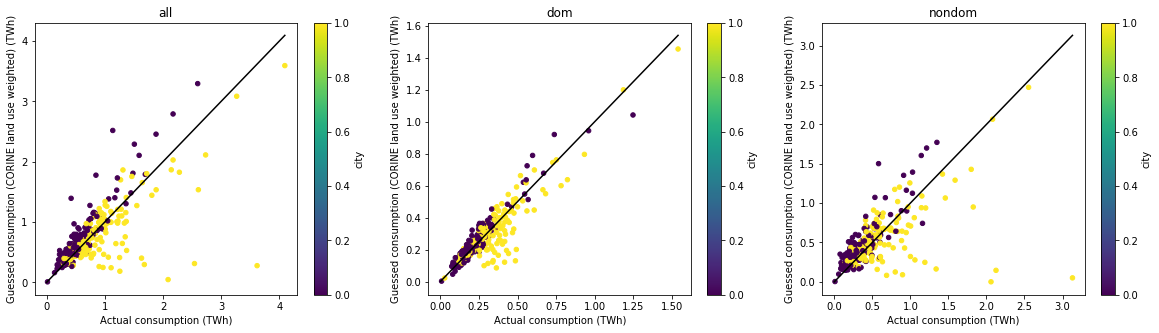

In [362]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

_ax = 0
for i in ['all', 'dom', 'nondom']:
    pd.DataFrame(uk_lau1_units).plot.scatter(ax=ax[_ax], x=f'consumption_{i}', y=f'raster_con_{i}', c='city', colormap='viridis')
    _max = uk_lau1_units[[f'raster_con_{i}', f'consumption_{i}']].max().max()
    ax[_ax].plot((0, _max), (0, _max), color='black')
    ax[_ax].set_xlabel('Actual consumption (TWh)')
    ax[_ax].set_ylabel('Guessed consumption (CORINE land use weighted) (TWh)')
    ax[_ax].set_title(i)
    _ax += 1

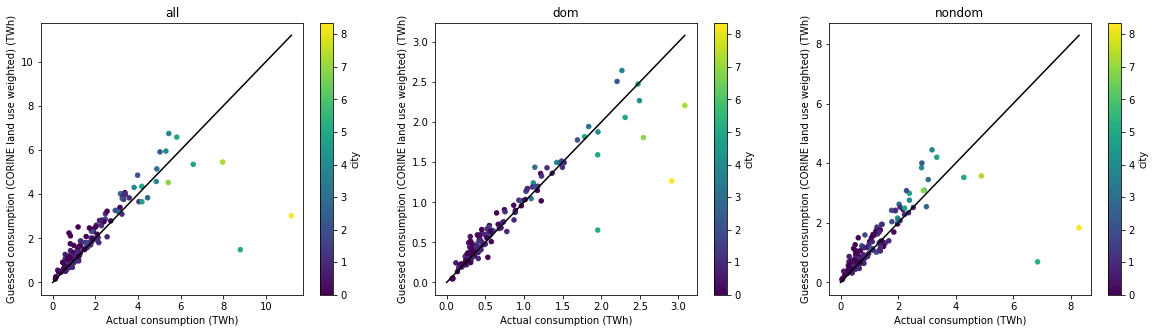

In [363]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

_ax = 0
for i in ['all', 'dom', 'nondom']:
    pd.DataFrame(uk_nuts3_2010_data).plot.scatter(ax=ax[_ax], x=f'consumption_{i}', y=f'raster_con_{i}', c='city', colormap='viridis')
    _max = uk_nuts3_2010_data[[f'raster_con_{i}', f'consumption_{i}']].max().max()
    ax[_ax].plot((0, _max), (0, _max), color='black')
    ax[_ax].set_xlabel('Actual consumption (TWh)')
    ax[_ax].set_ylabel('Guessed consumption (CORINE land use weighted) (TWh)')
    ax[_ax].set_title(i)
    _ax += 1

In [369]:
uk_nuts3_2010_data.sort_values('consumption_nondom', ascending=False).head()

,population,consumption_nondom,consumption_dom,consumption_all,pop_con_all,pop_con_dom,pop_con_nondom,city,hh_con_all,hh_con_nondom,hh_con_dom,raster_con_dom,raster_con_nondom,raster_con_all
id,,,,,,,,,,,,,,
UKI12,2.249100e+06,8.286082,2.912623,11.198705,10.136074,3.666438,6.469636,8.345549,9.352653,11.135403,3.352262,1.265883,1.835234,3.021744
UKI11,1.165827e+06,6.846556,1.956117,8.802673,5.254061,1.900508,3.353553,5.196491,5.552632,8.992608,1.976027,0.653667,0.690432,1.484720
UKI23,2.154956e+06,4.893012,3.083244,7.976256,9.711794,3.512967,6.198828,7.329189,7.903563,8.477170,2.838428,2.208956,3.571111,5.456901
UKD31,1.520341e+06,4.283273,2.310656,6.593929,6.851759,2.478430,4.373329,4.916183,6.808168,4.074877,2.464275,2.059546,3.523046,5.353759
UKJ42,1.401150e+06,3.343804,2.477321,5.821125,6.314596,2.284126,4.030470,4.863416,6.636819,4.668117,2.398106,2.475889,4.197686,6.588690


In [70]:
# Check the European settlement map data, instead of the Corine Land Cover data (ESM is what Tim's paper currently uses for land eligibility stuff)
def get_raster_tot(img):
    _img = img.flatten()
    _img = _img[~np.isnan(_img)]
    _img = _img.mean() * _img.size
    return _img

filedir = '/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/esm-{}.tif'
for k, v in {'bu': 'class303550-built-up', 'b': 'class50-buildings'}.items():
    with rasterio.open(filedir.format(v)) as src:
        clc = src.read(1)
        crs = src.crs
        uk_lau1_units_converted = uk_lau1_units.to_crs(crs)
        uk_nuts3_2010_converted = uk_nuts3_2010.to_crs(crs)
        _images = {}
        _transforms = {}
        _images_nuts = {}
        _transforms_nuts = {}
        for i in uk_lau1_units_converted.index:
            _images[i], _transforms[i] = rasterio.mask.mask(
                src, [uk_lau1_units_converted.loc[i, 'geometry']], 
                crop=True, nodata=np.nan
            )
        for i in uk_nuts3_2010_converted.index:
            _images_nuts[i], _transforms_nuts[i] = rasterio.mask.mask(
                src, [uk_nuts3_2010_converted.loc[i, 'geometry']], 
                crop=True, nodata=np.nan
            )
        _img_uk, _transform_uk = rasterio.mask.mask(
            src, europe_shape[europe_shape.country_code == 'GBR'].to_crs(crs).geometry.values, 
            crop=True, nodata=np.nan
        )
    
    _img_uk = get_raster_tot(_img_uk[0])
    for _k, _v in _images.items():
        _v = get_raster_tot(_v[0])
        uk_lau1_units.loc[_k, f'{k}_raster_con_dom'] = (_v / _img_uk) * uk_2018_dom_demand
        uk_lau1_units.loc[_k, f'{k}_raster_con_nondom'] = (_v / _img_uk) * uk_2018_nondom_demand
        uk_lau1_units.loc[_k, f'{k}_raster_con_all'] = (_v / _img_uk) * (uk_2018_dom_demand + uk_2018_nondom_demand)
        
    for _k, _v in _images_nuts.items():
        _v = get_raster_tot(_v[0])
        uk_nuts3_2010_data.loc[uk_nuts3_2010.loc[_k, 'id'], f'{k}_raster_con_dom'] = (_v / _img_uk) * uk_2018_dom_demand
        uk_nuts3_2010_data.loc[uk_nuts3_2010.loc[_k, 'id'], f'{k}_raster_con_nondom'] = (_v / _img_uk) * uk_2018_nondom_demand
        uk_nuts3_2010_data.loc[uk_nuts3_2010.loc[_k, 'id'], f'{k}_raster_con_all'] = (_v / _img_uk) * (uk_2018_dom_demand + uk_2018_nondom_demand)

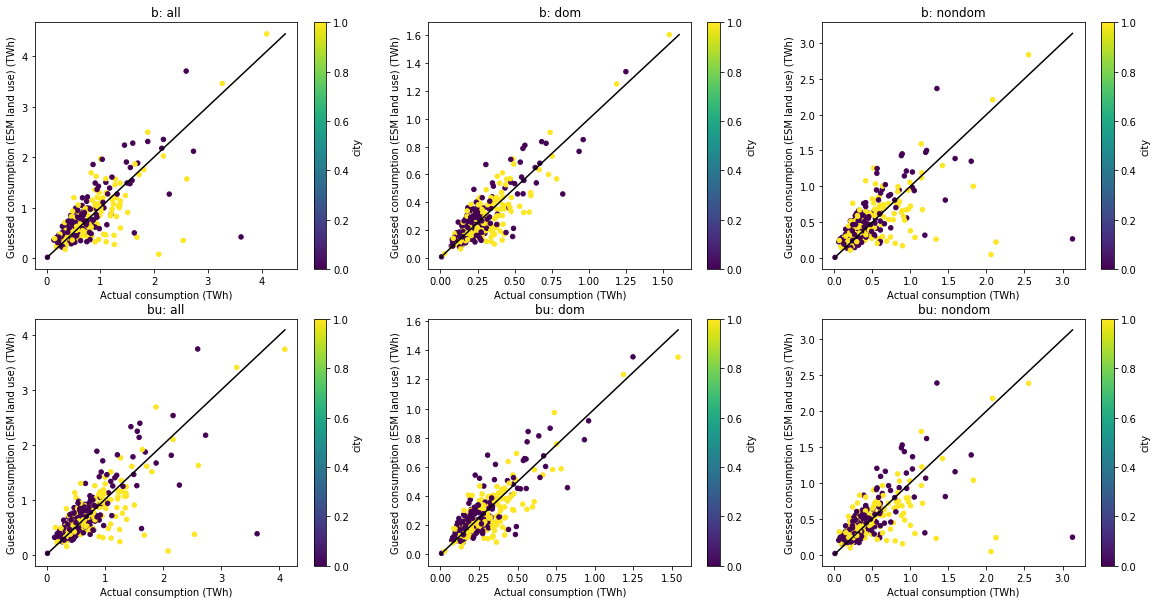

In [238]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

_ax1 = 0
for i in ['b', 'bu']: 
    _ax2 = 0
    for j in ['all', 'dom', 'nondom']:
        pd.DataFrame(uk_lau1_units).plot.scatter(ax=ax[_ax1, _ax2], x=f'consumption_{j}', y=f'{i}_raster_con_{j}', c='city', colormap='viridis')
        _max = uk_lau1_units[[f'{i}_raster_con_{j}', f'consumption_{j}']].max().max()
        ax[_ax1, _ax2].plot((0, _max), (0, _max), color='black')
        ax[_ax1, _ax2].set_title(f'{i}: {j}')
        ax[_ax1, _ax2].set_xlabel('Actual consumption (TWh)')
        ax[_ax1, _ax2].set_ylabel('Guessed consumption (ESM land use) (TWh)')
        _ax2 += 1
    _ax1 += 1

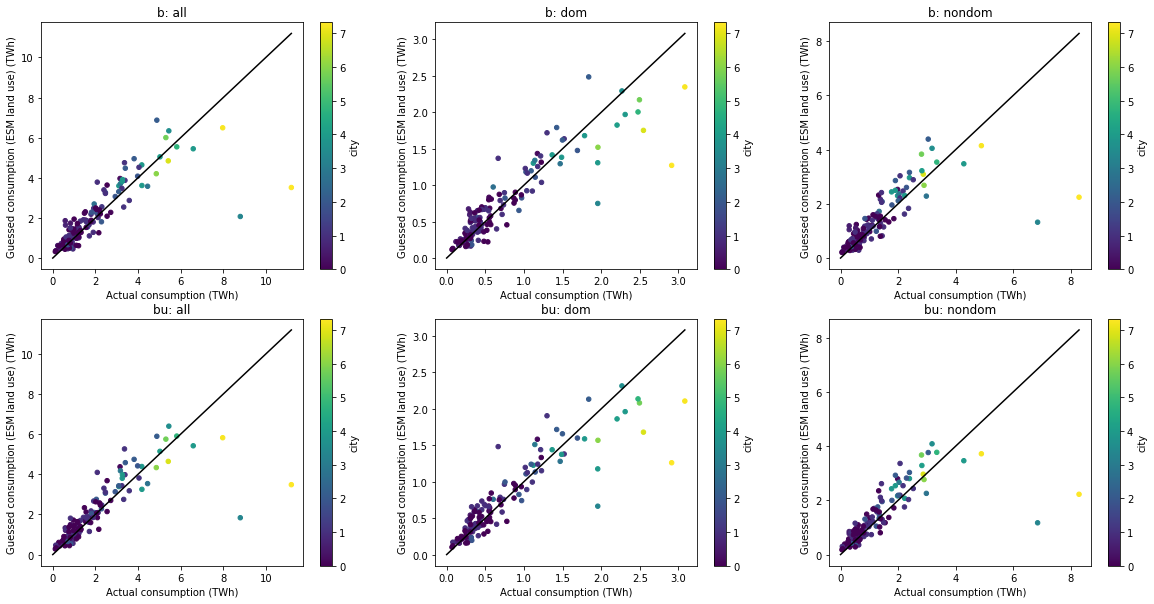

In [237]:
# Again, check with nuts3 aggregation
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

_ax1 = 0
for i in ['b', 'bu']: 
    _ax2 = 0
    for j in ['all', 'dom', 'nondom']:
        pd.DataFrame(uk_nuts3_2010_data).plot.scatter(ax=ax[_ax1, _ax2], x=f'consumption_{j}', y=f'{i}_raster_con_{j}', c='city', colormap='viridis')
        _max = uk_nuts3_2010_data[[f'{i}_raster_con_{j}', f'consumption_{j}']].max().max()
        ax[_ax1, _ax2].plot((0, _max), (0, _max), color='black')
        ax[_ax1, _ax2].set_title(f'{i}: {j}')
        ax[_ax1, _ax2].set_xlabel('Actual consumption (TWh)')
        ax[_ax1, _ax2].set_ylabel('Guessed consumption (ESM land use) (TWh)')
        _ax2 += 1
    _ax1 += 1

# Check EU-ETS for non-domestic data

In [239]:
# Load scraped data and reorganise things
industrial_units = pd.read_csv(
    '/cluster/work/cpesm/brynmorp/euro-spores/data/industry/industrial_plant_metadata.csv', 
    usecols=['REGISTRY_COD', 'MAIN_ACTIVITY_TYPE_CODE', 'lat', 'lon', 'PERMIT_IDENTIFIER']
).set_index('PERMIT_IDENTIFIER')
industrial_units = industrial_units[industrial_units.REGISTRY_COD == 'GB']
ind_pts = [shapely.geometry.Point(xy) for xy in zip(industrial_units.lon.values, industrial_units.lat.values)]
industrial_units = gpd.GeoDataFrame(industrial_units, geometry=ind_pts, crs='epsg:4326').drop(['lat', 'lon', 'REGISTRY_COD'], axis=1)

industrial_emissions = pd.read_csv('/cluster/work/cpesm/brynmorp/euro-spores/data/industry/industrial_emissions.csv', index_col=0)['2018']
industrial_activity_codes = pd.read_csv(
    '/cluster/work/cpesm/brynmorp/euro-spores/data/industry/industry_activity_codes.csv', 
    skipfooter=7, index_col=0, header=0, engine='python'
).dropna(subset=['Eurostat sector'])

industrial_emissions = industrial_emissions.reindex(industrial_units.index)
industrial_units['emissions'] = industrial_emissions.where(industrial_emissions.str.isnumeric()).astype(float)

In [245]:
# Pinpoint which LAU1 an industry unit is in
industry_points_per_lau1 = gpd.sjoin(industrial_units, uk_lau1_units.to_crs('epsg:4326'), how='right', op='within')
industry_points_per_lau1 = industry_points_per_lau1.reset_index().assign(industry_counter=1).groupby(['index_right', 'MAIN_ACTIVITY_TYPE_CODE'])[['emissions', 'industry_counter']].sum()

# Group plants by their activity type (mathcing energy balances)
industry_activity_per_lau1 = industry_points_per_lau1.reset_index()
industry_activity_per_lau1['MAIN_ACTIVITY_TYPE_CODE'] = industry_activity_per_lau1.MAIN_ACTIVITY_TYPE_CODE.map(industrial_activity_codes['Eurostat sector'].to_dict()).dropna()
industry_activity_per_lau1 = industry_activity_per_lau1.groupby(['index_right', 'MAIN_ACTIVITY_TYPE_CODE']).sum()

In [241]:
# This is from the equivalent of the Eurostat energy balances, but for emissions.
uk_emissions_2018 = pd.DataFrame.from_dict({
    'FC_IND_IS_E': 9323.19 * 1000 ,
    'FC_IND_CPC_E': 5315.91 * 1000,
    'FC_IND_NFM_E': 733.78 * 1000 ,
    'FC_IND_NMM_E': 2578.55 * 1000 ,
    'FC_IND_PPP_E': 1471.43 * 1000,
    'FC_IND_NSP_E': 27913.05 * 1000 ,
}, orient='index').iloc[:, 0]

In [246]:
industry_con_lau1.reindex(uk_lau1_units.index).fillna(0).head()

,emissions,counter,emissions_con
LA Code,,,
E06000001,15258.0,1.0,0.004190
E06000002,0.0,0.0,0.000000
E06000003,140200.0,5.0,0.151415
E06000004,1095660.0,3.0,3.146888
E06000005,65699.0,1.0,0.188697


In [364]:
# Take electricity consumption as being proportional to the plant's contribution to sub-sector emissions
industry_activity_per_lau1['emissions_con'] = (
    uk_industry_2018.to_dataframe().UK.reindex(industry_activity_per_lau1.index.get_level_values(1)).values 
    * industry_activity_per_lau1.emissions / 
    uk_emissions_2018.reindex(industry_activity_per_lau1.index.get_level_values(1)).values
)
industry_con_lau1 = industry_activity_per_lau1.groupby(level=0).sum()
uk_lau1_units[['emissions_con', 'industry_counter']] = industry_con_lau1.reindex(uk_lau1_units.index).fillna(0)[['emissions_con', 'industry_counter']]

Text(0.5, 1.0, 'bu')

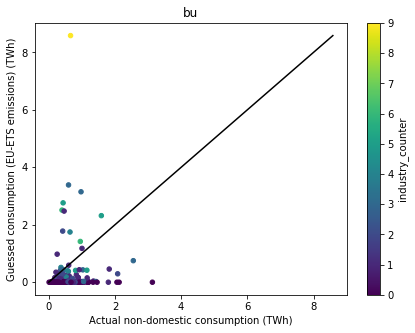

In [250]:
# useless...
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

pd.DataFrame(uk_lau1_units).plot.scatter(ax=ax, x='consumption_nondom', y='emissions_con', c='industry_counter', colormap='viridis')
_max = uk_lau1_units[['consumption_nondom', 'emissions_con']].max().max()
ax.plot((0, _max), (0, _max), color='black')
ax.set_xlabel('Actual non-domestic consumption (TWh)')
ax.set_ylabel('Guessed consumption (EU-ETS emissions) (TWh)')
ax.set_title(i)

In [367]:
uk_lau1_units.sort_values('consumption_nondom', ascending=False)

,LAD19NM,geometry,population,nuts3,area_m2,city,consumption_all,consumption_dom,consumption_nondom,pop_density,pop_con_all,pop_con_dom,pop_con_nondom,population_tif,area3035,raster_con_dom,raster_con_nondom,raster_con_all,emissions_con,industry_counter
LA Code,,,,,,,,,,,,,,,,,,,,
E09000033,Westminster,"POLYGON ((-0.17401 51.53804, -0.17407 51.53811...",244796.0,UKI32,2.203010e+07,1.0,3.616914,0.486066,3.130847,0.011112,1.103228,0.399062,0.704167,2.316624e+05,2.203839e+07,0.129595,0.050601,0.278141,0.000000,0.0
E08000025,Birmingham,"POLYGON ((-1.82482 52.60778, -1.82658 52.60829...",1137123.0,UKG31,2.677913e+08,1.0,4.093413,1.539476,2.553937,0.004246,5.124700,1.853715,3.270985,1.103350e+06,2.679922e+08,1.454163,2.470800,3.592364,0.749467,3.0
E09000030,Tower Hamlets,"POLYGON ((-0.02899 51.54229, -0.02913 51.54257...",307964.0,UKI42,2.157500e+07,1.0,2.541455,0.415727,2.125727,0.014274,1.387909,0.502037,0.885872,2.799282e+05,2.158172e+07,0.121168,0.146270,0.313010,0.000000,0.0
E08000035,Leeds,"POLYGON ((-1.34057 53.94488, -1.34012 53.94533...",784846.0,UKE42,5.517065e+08,1.0,3.266582,1.185564,2.081018,0.001423,3.537085,1.279440,2.257644,7.604411e+05,5.520982e+08,1.198998,2.065647,3.084477,0.292682,2.0
E09000001,City of London,"POLYGON ((-0.09669 51.52319, -0.09676 51.52332...",7654.0,UKI31,3.149600e+06,1.0,2.088199,0.028144,2.060055,0.002430,0.034494,0.012477,0.022017,9.050529e+03,3.150478e+06,0.022169,0.000692,0.047579,0.000000,0.0
E08000003,Manchester,"POLYGON ((-2.24196 53.54139, -2.24241 53.54163...",545501.0,UKD33,1.156486e+08,1.0,2.608248,0.781767,1.826481,0.004717,2.458423,0.889265,1.569158,5.495328e+05,1.157336e+08,0.599385,0.950813,1.535884,0.458034,1.0
S12000049,Glasgow City,"POLYGON ((-4.12529 55.88575, -4.12520 55.88545...",621020.0,UKM82,1.764325e+08,1.0,2.732759,0.932885,1.799874,0.003520,2.798766,1.012374,1.786392,5.969865e+05,1.763950e+08,0.795333,1.429159,2.112533,0.000000,1.0
E06000050,Cheshire West and Chester,"POLYGON ((-2.49488 53.34214, -2.49483 53.34218...",337986.0,UKD63,9.412071e+08,1.0,2.142858,0.554944,1.587914,0.000359,1.523210,0.550978,0.972232,3.308187e+05,9.418482e+08,0.617378,1.291534,1.865840,2.316690,5.0
S12000036,City of Edinburgh,"MULTIPOLYGON (((-3.38718 56.00117, -3.38734 56...",513210.0,UKM75,2.730443e+08,1.0,2.282224,0.823011,1.459213,0.001880,2.312896,0.836625,1.476271,4.855996e+05,2.731540e+08,0.636813,1.065155,1.825919,0.000000,0.0


# Actually check Tim's Euro-Calliope data

In [260]:
def get_absolute_vals(df):
    df['trtim_con_nondom'] = df.demand_twh_per_year * df.industrial_demand_fraction
    df['trtim_con_dom'] = df.demand_twh_per_year - df.trtim_con_nondom
    df['trtim_con_all'] = df.demand_twh_per_year
    return df

nuts3_2006_units = gpd.read_file('/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/subregional/units.geojson')
nuts3_2006_con = pd.read_csv('/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/subregional/demand.csv')
nuts3_2006_con = get_absolute_vals(nuts3_2006_con)

nuts3_2006_pop = pd.read_csv('/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/subregional/population.csv')

nuts3_2006_units = nuts3_2006_units[nuts3_2006_units.country_code == 'GBR']
nuts3_2006_units['area3035'] = nuts3_2006_units.to_crs('epsg:3035').area
nuts3_2006_units[['trtim_con_dom', 'trtim_con_nondom', 'trtim_con_all']] = (
    nuts3_2006_con[['id','trtim_con_dom', 'trtim_con_nondom', 'trtim_con_all']]
    .set_index('id').reindex(nuts3_2006_units.id).set_index(nuts3_2006_units.index)
)
nuts3_2006_units['population_nuts2006'] = (
    nuts3_2006_pop[['id', 'population_sum']]
    .set_index('id').reindex(nuts3_2006_units.id).set_index(nuts3_2006_units.index)
)

In [261]:
nuts_2006_to_2010 = gpd.overlay(nuts3_2006_units, uk_nuts3_2010)
nuts_2006_to_2010_area_percent = nuts_2006_to_2010.to_crs('epsg:3035').area / nuts_2006_to_2010.area3035

In [262]:
uk_nuts3_2010_data[['population_nuts2006', 'trtim_con_dom', 'trtim_con_nondom', 'trtim_con_all']] = (
    nuts_2006_to_2010[['population_nuts2006', 'trtim_con_dom', 'trtim_con_nondom', 'trtim_con_all']]
    .mul(nuts_2006_to_2010_area_percent, axis=0)
    .set_index(nuts_2006_to_2010.id_2)
    .groupby(level=0).sum()
)

In [141]:
lau2_2013_units = gpd.read_file('/cluster/work/cpesm/trtim/possibility-for-electricity-autarky/build/municipal/units.geojson')
lau2_2013_con = pd.read_csv('/cluster/work/cpesm/trtim/possibility-for-electricity-autarky/build/municipal/demand.csv')
lau2_2013_con = get_absolute_vals(lau2_2013_con)

lau2_2013_units = lau2_2013_units[lau2_2013_units.country_code == 'GBR']
lau2_2013_units['area3035'] = lau2_2013_units.to_crs('epsg:3035').area
lau2_2013_units[['trtim_con_dom', 'trtim_con_nondom', 'trtim_con_all']] = (
    lau2_2013_con[['id','trtim_con_dom', 'trtim_con_nondom', 'trtim_con_all']]
    .set_index('id').reindex(lau2_2013_units.id).set_index(lau2_2013_units.index)
)

In [149]:
lau2_to_lau1 = gpd.overlay(lau2_2013_units, uk_lau1_units)
lau2_to_lau1_area_percent = commune_to_lau1.to_crs('epsg:3035').area / commune_to_lau1['commune_area3035']

In [153]:
commune_to_lau1_data = (
    lau2_to_lau1[['trtim_con_dom', 'trtim_con_nondom', 'trtim_con_all']]
    .mul(lau2_to_lau1_area_percent, axis=0)
    .set_index(lau2_to_lau1.LAD19NM)
    .groupby(level=0).sum()
)
uk_lau1_units[['trtim_con_dom', 'trtim_con_nondom', 'trtim_con_all']] = (
    commune_to_lau1_data.reindex(uk_lau1_units.LAD19NM).set_index(uk_lau1_units.index)
)

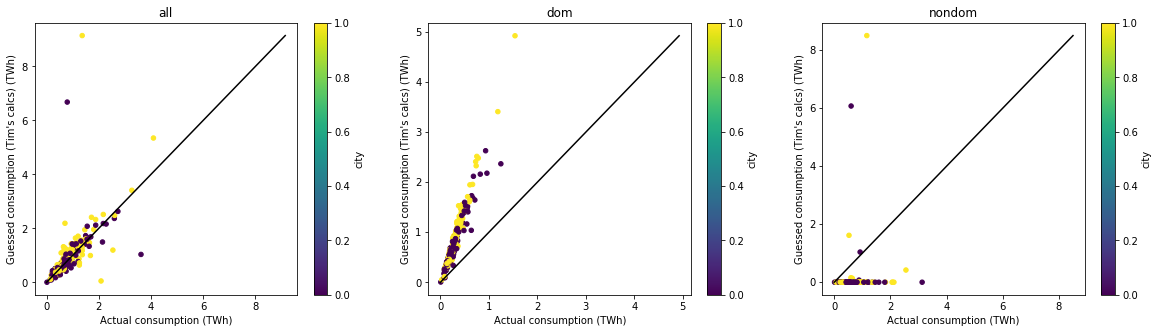

In [154]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

_ax = 0
for i in ['all', 'dom', 'nondom']:
    pd.DataFrame(uk_lau1_units).plot.scatter(ax=ax[_ax], x=f'consumption_{i}', y=f'trtim_con_{i}', c='city', colormap='viridis')
    _max = uk_lau1_units[[f'trtim_con_{i}', f'consumption_{i}']].max().max()
    ax[_ax].plot((0, _max), (0, _max), color='black')
    ax[_ax].set_xlabel('Actual consumption (TWh)')
    ax[_ax].set_ylabel("Guessed consumption (Tim's calcs) (TWh)")
    ax[_ax].set_title(i)
    _ax += 1

Text(0, 0.5, "Guessed consumption (Tim's calcs) (TWh)")

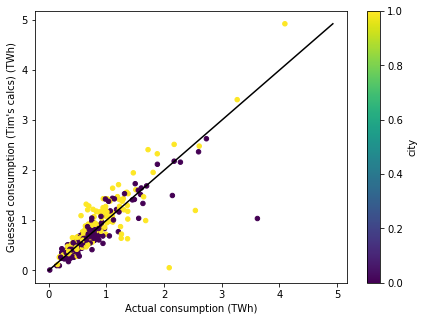

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

pd.DataFrame(uk_lau1_units).plot.scatter(ax=ax, x='consumption_all', y='trtim_con_dom', c='city', colormap='viridis')
_max = uk_lau1_units[['trtim_con_dom', 'consumption_all']].max().max()
ax.plot((0, _max), (0, _max), color='black')
ax.set_xlabel('Actual consumption (TWh)')
ax.set_ylabel("Guessed consumption (Tim's calcs) (TWh)")

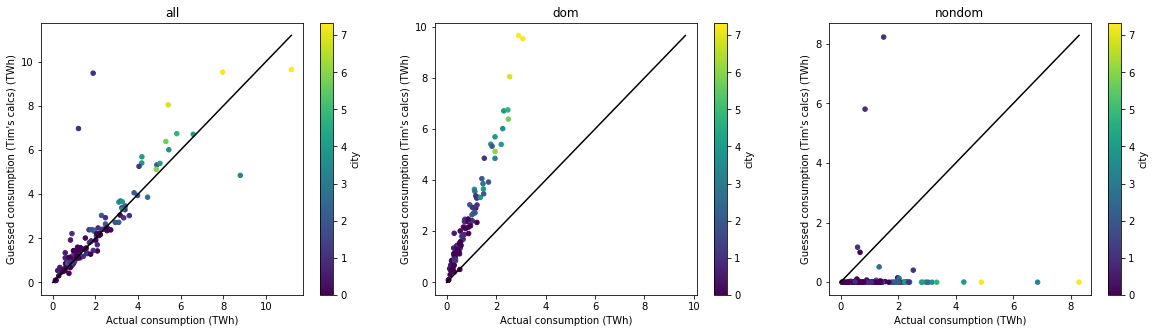

In [143]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

_ax = 0
for i in ['all', 'dom', 'nondom']:
    pd.DataFrame(uk_nuts3_2010_data).plot.scatter(ax=ax[_ax], x=f'consumption_{i}', y=f'trtim_con_{i}', c='city', colormap='viridis')
    _max = uk_nuts3_2010_data[[f'trtim_con_{i}', f'consumption_{i}']].max().max()
    ax[_ax].plot((0, _max), (0, _max), color='black')
    ax[_ax].set_xlabel('Actual consumption (TWh)')
    ax[_ax].set_ylabel("Guessed consumption (Tim's calcs) (TWh)")
    ax[_ax].set_title(i)
    _ax += 1

Text(0.5, 1.0, 'nondom')

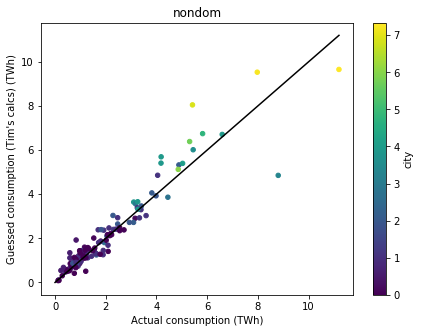

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

pd.DataFrame(uk_nuts3_2010_data).plot.scatter(ax=ax, x='consumption_all', y='trtim_con_dom', c='city', colormap='viridis')
_max = uk_nuts3_2010_data[['trtim_con_dom', 'consumption_all']].max().max()
ax.plot((0, _max), (0, _max), color='black')
ax.set_xlabel('Actual consumption (TWh)')
ax.set_ylabel("Guessed consumption (Tim's calcs) (TWh)")
ax.set_title(i)

# Check against employment/GDP

In [252]:
nuts3_employment = pd.read_excel( # Data = 'employed persons', Data2 = 'employees'
    '../../data/eu_employment_nuts3.xls', sheet_name='Data', skiprows=9
)
nuts3_gdp =  pd.read_excel(
    '../../data/eu_gdp_nuts3.xls', sheet_name='Data', skiprows=8
)

In [253]:
uk_nuts3_employment = nuts3_employment[nuts3_employment['NACE_R2'].str.find('UK') > -1]
uk_nuts3_employment.index = uk_nuts3_employment.NACE_R2.str.split(' - ', expand=True)[0]
employment_nondom_demand = (
    uk_nuts3_employment.reindex(uk_lau1_units.groupby('nuts3').sum().index)
    ['Total - all NACE activities'].transform(lambda x: x / x.sum()) * uk_2018_nondom_demand
)

In [254]:
nuts3_gdp = nuts3_gdp.loc[nuts3_gdp['GEO/TIME'].str.find('UK') > -1, ['GEO/TIME', '2018']]
nuts3_gdp.index = nuts3_gdp['GEO/TIME'].str.split(' - ', expand=True)[0]
gdp_nondom_demand = (
    nuts3_gdp.reindex(uk_lau1_units.groupby('nuts3').sum().index)
    ['2018'].transform(lambda x: x / x.sum()) * uk_2018_nondom_demand
)

In [255]:
uk_nuts3_2016_units = uk_lau1_units.dissolve('nuts3', aggfunc='sum')

In [256]:
uk_nuts3_2016_units['employment_con_nondom'] = employment_nondom_demand.reindex(uk_nuts3_2016_units.index).astype('float')
uk_nuts3_2016_units['gdp_con_nondom'] = gdp_nondom_demand.reindex(uk_nuts3_2016_units.index).astype('float')

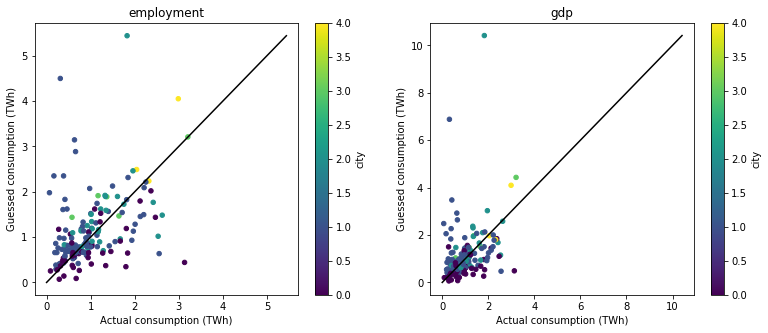

In [257]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

_ax = 0
for i in ['employment', 'gdp']:
    pd.DataFrame(uk_nuts3_2016_units).plot.scatter(ax=ax[_ax], x='consumption_nondom', y=f'{i}_con_nondom', c='city', colormap='viridis')
    _max = uk_nuts3_2016_units[[f'{i}_con_nondom', 'consumption_nondom']].max().max()
    ax[_ax].plot((0, _max), (0, _max), color='black')
    ax[_ax].set_xlabel('Actual consumption (TWh)')
    ax[_ax].set_ylabel("Guessed consumption (TWh)")
    ax[_ax].set_title(i)
    _ax += 1

In [370]:
# What about 60:40 gdp:pop (a la Tom Brown)?
uk_nuts3_2016_units['pypsa_con_all'] = (
    0.6 * nuts3_gdp.reindex(uk_lau1_units.groupby('nuts3').sum().index)['2018'].transform(lambda x: x / x.sum()) * (uk_2018_dom_demand + uk_2018_nondom_demand) +
    0.4 * uk_nuts3_2016_units.population.transform(lambda x: x / x.sum()) * (uk_2018_dom_demand + uk_2018_nondom_demand)
).astype(float)
    

Text(0, 0.5, 'Guessed consumption (PyPSA Europe) (TWh)')

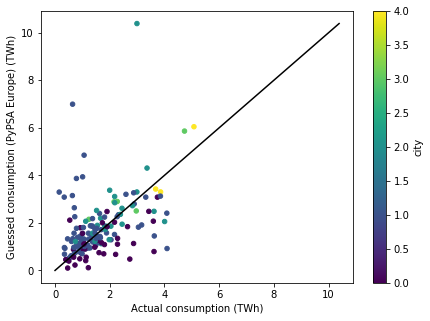

In [371]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

pd.DataFrame(uk_nuts3_2016_units).dropna(subset=['pypsa_con_all']).plot.scatter(ax=ax, x='consumption_all', y='pypsa_con_all', c='city', colormap='viridis')
_max = uk_nuts3_2016_units.dropna(subset=['pypsa_con_all'])[['pypsa_con_all', 'consumption_all']].max().max()
ax.plot((0, _max), (0, _max), color='black')
ax.set_xlabel('Actual consumption (TWh)')
ax.set_ylabel("Guessed consumption (PyPSA Europe) (TWh)")

# Look at correlations

In [373]:
uk_nuts3_2010_data.corr()

,population,consumption_nondom,consumption_dom,consumption_all,pop_con_all,pop_con_dom,pop_con_nondom,city,hh_con_all,hh_con_nondom,hh_con_dom,raster_con_dom,raster_con_nondom,raster_con_all
population,1.000000,0.891626,0.964781,0.942123,1.000000,1.000000,1.000000,0.877831,0.977849,0.875573,0.977662,0.868242,0.834212,0.827087
consumption_nondom,0.891626,1.000000,0.885301,0.985942,0.891626,0.891626,0.891626,0.812437,0.903738,0.903332,0.902073,0.724510,0.692375,0.703956
consumption_dom,0.964781,0.885301,1.000000,0.950554,0.964781,0.964781,0.964781,0.821624,0.978958,0.854449,0.979122,0.930389,0.901596,0.902024
consumption_all,0.942123,0.985942,0.950554,1.000000,0.942123,0.942123,0.942123,0.837800,0.955306,0.910297,0.954253,0.818158,0.786351,0.794239
pop_con_all,1.000000,0.891626,0.964781,0.942123,1.000000,1.000000,1.000000,0.877831,0.977849,0.875573,0.977662,0.868242,0.834212,0.827087
pop_con_dom,1.000000,0.891626,0.964781,0.942123,1.000000,1.000000,1.000000,0.877831,0.977849,0.875573,0.977662,0.868242,0.834212,0.827087
pop_con_nondom,1.000000,0.891626,0.964781,0.942123,1.000000,1.000000,1.000000,0.877831,0.977849,0.875573,0.977662,0.868242,0.834212,0.827087
city,0.877831,0.812437,0.821624,0.837800,0.877831,0.877831,0.877831,1.000000,0.860845,0.831653,0.859715,0.672844,0.634780,0.617771
hh_con_all,0.977849,0.903738,0.978958,0.955306,0.977849,0.977849,0.977849,0.860845,1.000000,0.885045,0.999973,0.895025,0.862923,0.859150
hh_con_nondom,0.875573,0.903332,0.854449,0.910297,0.875573,0.875573,0.875573,0.831653,0.885045,1.000000,0.881586,0.649388,0.590344,0.594372


In [374]:
pd.DataFrame(uk_nuts3_2016_units).corr()

,population,area_m2,city,consumption_all,consumption_dom,consumption_nondom,pop_density,pop_con_all,pop_con_dom,pop_con_nondom,...,trtim_con_nondom,trtim_con_all,emissions_con,couindustry_counternter,couindustry_counter,industry_counter,employment_con_nondom,gdp_con_nondom,population_tif,pypsa_con_all
population,1.000000,0.111596,0.569324,0.602053,0.639085,0.543225,0.417341,1.000000,1.000000,1.000000,...,0.013614,0.509812,0.171383,0.287094,0.287094,0.287094,0.724162,0.466432,0.635635,0.667562
area_m2,0.111596,1.000000,-0.293554,0.200112,0.223179,0.174352,-0.275510,0.111596,0.111596,0.111596,...,-0.060531,0.077550,0.049878,0.228167,0.228167,0.228167,0.036373,-0.052502,0.142967,-0.007183
city,0.569324,-0.293554,1.000000,0.386514,0.435064,0.334454,0.580977,0.569324,0.569324,0.569324,...,0.009503,0.381060,-0.034366,0.016452,0.016452,0.016452,0.483402,0.393783,0.476830,0.474950
consumption_all,0.602053,0.200112,0.386514,1.000000,0.930991,0.977577,0.343314,0.602053,0.602053,0.602053,...,0.044521,0.758141,0.096869,0.316828,0.316828,0.316828,0.470720,0.355248,0.927537,0.453393
consumption_dom,0.639085,0.223179,0.435064,0.930991,1.000000,0.833247,0.337839,0.639085,0.639085,0.639085,...,-0.017003,0.757868,0.038202,0.287822,0.287822,0.287822,0.491679,0.357499,0.975622,0.466588
consumption_nondom,0.543225,0.174352,0.334454,0.977577,0.833247,1.000000,0.325107,0.543225,0.543225,0.543225,...,0.077241,0.711119,0.124683,0.313844,0.313844,0.313844,0.428480,0.331170,0.842077,0.418147
pop_density,0.417341,-0.275510,0.580977,0.343314,0.337839,0.325107,1.000000,0.417341,0.417341,0.417341,...,-0.010429,0.312865,-0.065345,-0.052976,-0.052976,-0.052976,0.502361,0.529757,0.406220,0.550492
pop_con_all,1.000000,0.111596,0.569324,0.602053,0.639085,0.543225,0.417341,1.000000,1.000000,1.000000,...,0.013614,0.509812,0.171383,0.287094,0.287094,0.287094,0.724162,0.466432,0.635635,0.667562
pop_con_dom,1.000000,0.111596,0.569324,0.602053,0.639085,0.543225,0.417341,1.000000,1.000000,1.000000,...,0.013614,0.509812,0.171383,0.287094,0.287094,0.287094,0.724162,0.466432,0.635635,0.667562
pop_con_nondom,1.000000,0.111596,0.569324,0.602053,0.639085,0.543225,0.417341,1.000000,1.000000,1.000000,...,0.013614,0.509812,0.171383,0.287094,0.287094,0.287094,0.724162,0.466432,0.635635,0.667562


In [376]:
pd.DataFrame(uk_lau1_units).corr()

,population,area_m2,city,consumption_all,consumption_dom,consumption_nondom,pop_density,pop_con_all,pop_con_dom,pop_con_nondom,population_tif,area3035,raster_con_dom,raster_con_nondom,raster_con_all,emissions_con,industry_counter
population,1.000000,0.031801,0.413663,0.869180,0.968558,0.748300,0.352672,1.000000,1.000000,1.000000,0.999088,0.031812,0.878464,0.832137,0.808381,0.053158,0.201238
area_m2,0.031801,1.000000,-0.390220,0.089357,0.169769,0.044205,-0.311191,0.031801,0.031801,0.031801,0.039052,1.000000,0.241721,0.306724,0.350380,-0.023741,0.001983
city,0.413663,-0.390220,1.000000,0.361516,0.307147,0.355854,0.531549,0.413663,0.413663,0.413663,0.412553,-0.390208,0.175065,0.137519,0.101039,0.064675,0.038402
consumption_all,0.869180,0.089357,0.361516,1.000000,0.875137,0.973370,0.375863,0.869180,0.869180,0.869180,0.869579,0.108949,0.765761,0.736143,0.737061,0.117334,0.239662
consumption_dom,0.968558,0.169769,0.307147,0.875137,1.000000,0.740908,0.257539,0.968558,0.968558,0.968558,0.964009,0.175594,0.919751,0.872417,0.863527,0.047742,0.178087
consumption_nondom,0.748300,0.044205,0.355854,0.973370,0.740908,1.000000,0.398787,0.748300,0.748300,0.748300,0.750245,0.068030,0.627117,0.608432,0.613917,0.140238,0.248274
pop_density,0.352672,-0.311191,0.531549,0.375863,0.257539,0.398787,1.000000,0.352672,0.352672,0.352672,0.345766,-0.311185,-0.054059,-0.113279,-0.121881,-0.062299,-0.126169
pop_con_all,1.000000,0.031801,0.413663,0.869180,0.968558,0.748300,0.352672,1.000000,1.000000,1.000000,0.999088,0.031812,0.878464,0.832137,0.808381,0.053158,0.201238
pop_con_dom,1.000000,0.031801,0.413663,0.869180,0.968558,0.748300,0.352672,1.000000,1.000000,1.000000,0.999088,0.031812,0.878464,0.832137,0.808381,0.053158,0.201238
pop_con_nondom,1.000000,0.031801,0.413663,0.869180,0.968558,0.748300,0.352672,1.000000,1.000000,1.000000,0.999088,0.031812,0.878464,0.832137,0.808381,0.053158,0.201238
